In [ ]:
import tensorflow as tf
import keras
keras.__version__

'2.4.3'

# Understanding recurrent neural networks

A recurrent neural network (RNN) processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In general case, an RNN will take as an input $n$ elements of a sequence and process it in $n$ steps. At each step, it will "memorise" it's inner state a and pass it to the next "pass" of a neural network. In a diagram, we often depict it as an "unfolded" sequence of $t$ steps, each of which will have and input $x^i$, output $\hat{y^i}$, incoming hidden state $a^{t-1}$ from a previous element and outgoing hidden state $a^t$ that will be used in the next element.

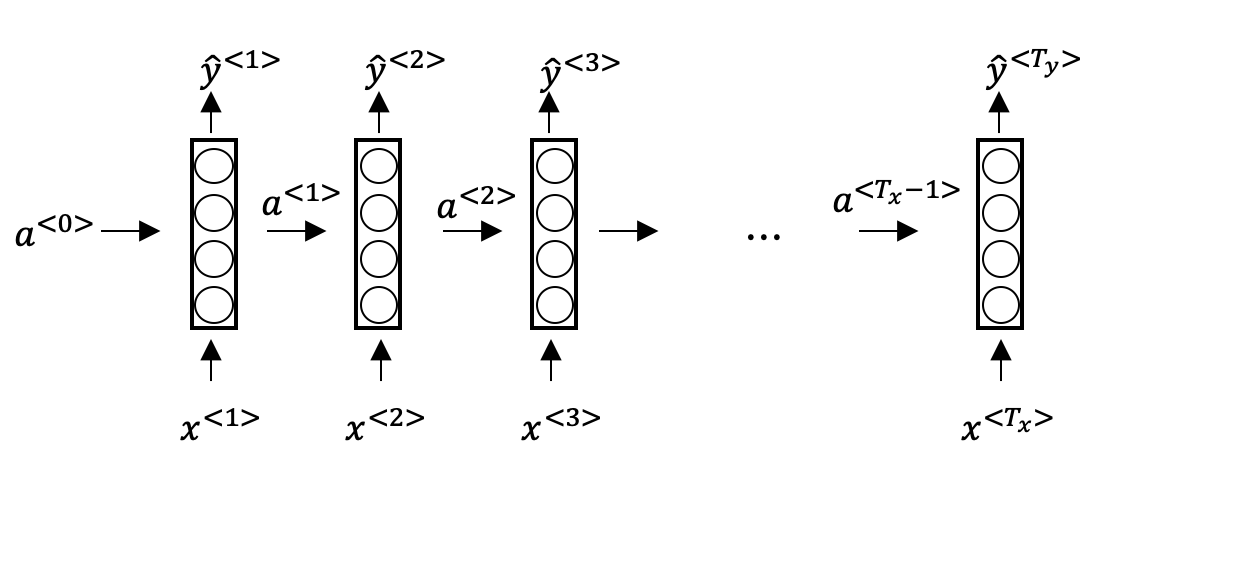

On the last time step our RNN inputs $x^{T_x}$ and then it outputs $\hat{y}^{T_y}$. In this example, a number of steps $T_x$ is equal to $T_y$, but the architecture will change a bit if $T_x$ and $T_y$ are not identical. So at each time step, the recurrent neural network that passes on as activation to the next time step for it to use. And to start the processing of the first unit, we'll also have some made-up activation at time zero, this is usually the vector of zeros. Some researchers will initialized $a^0$ randomly. You have other ways to initialize $a^0$ but really having a vector of zeros as the fake times zero activation is the most common choice. So that gets input to the neural network.

The recurrent neural network scans through the data from left to right. The parameters it uses for each time step are shared. In order to train such neural network, we will also need a set  of parameters. The parameters governing the connection from $x_1$ to the hidden layer, will be some set of parameters we're going to write as $\omega_{ax}$ and this is the same parameters that are used for every time step. The activations (the horizontal connections) will have some set of parameters $\omega_{aa}$ and the same parameters $\omega_{aa}$ will be used on every timestep and similarly the sum $\omega_{ya}$ that governs the output predictions.

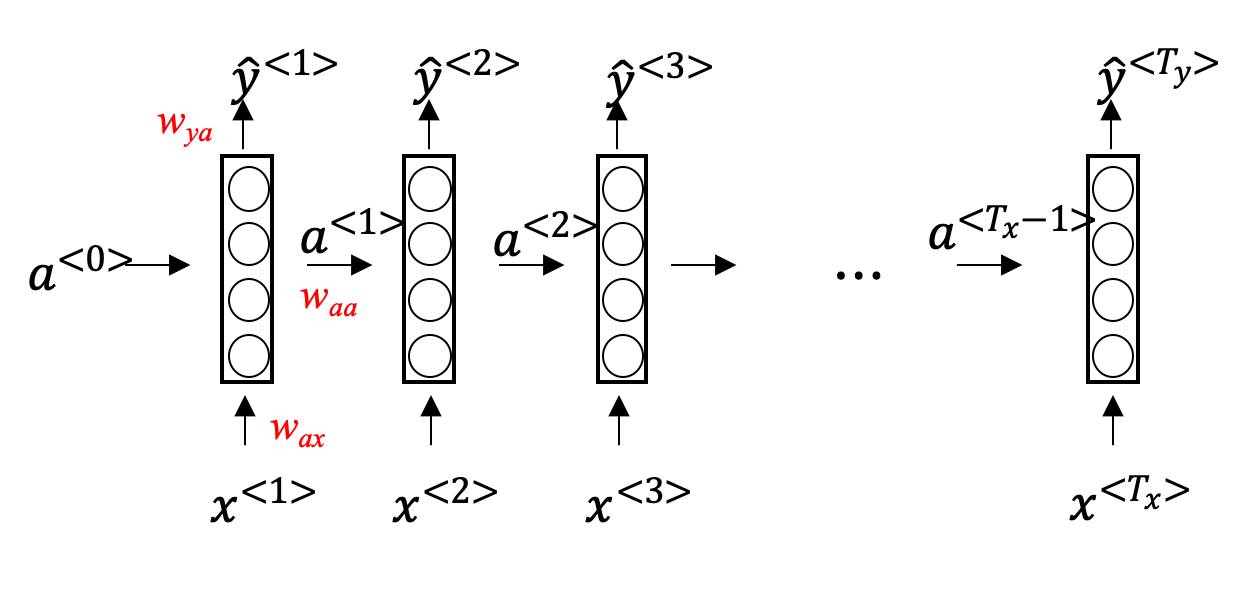

In this recurrent neural network, what this means is that when making the prediction for $y^n$, it gets the information not only from $x^n$ but also the information from $x^{n-1}$ and $x^{n+1}$ because the information on $x^{n-1}$ can help to predict $y^n$. One limitation of this particular neural network structure is that the prediction at a certain time uses inputs or uses information from the inputs earlier in the sequence but not information later in the sequence.

Now, let's define the steps of the neural network more formally. First, we initialise the activation $a^0$ with a vector of zeros:

\begin{equation}
    a_0 = \overrightarrow{0}
\end{equation}

On step one, we calculate activation $a_1$ and output $\hat{y_1}$ of the RNN:

\begin{equation}
    a_1 = g(\omega_{aa} a_0 + \omega_{ax}x^1 + b_a ),
\end{equation}
where the model output is computed as
\begin{equation}
    \hat{y}^1 = h(\omega_{ya}a^1 + b_y),
\end{equation}

where $g$ and $h$ are activation functions, such as hyperbolic tangent, rectified linear unit (ReLu) or sigmoid.

Step $t$, therefore,  can be described as following:
\begin{equation}
    a^t = g(\omega_{aa} a_{t-1} + \omega_{ax}x^t + b_a ),
\end{equation}
and
\begin{equation}
    \hat{y}^t = h(\omega_{ya}a^t + b_y).
\end{equation}

Sometimes, visualisation of this process is slightly easier to understand. Next image depicts the calculations, made in a single cell, in details.

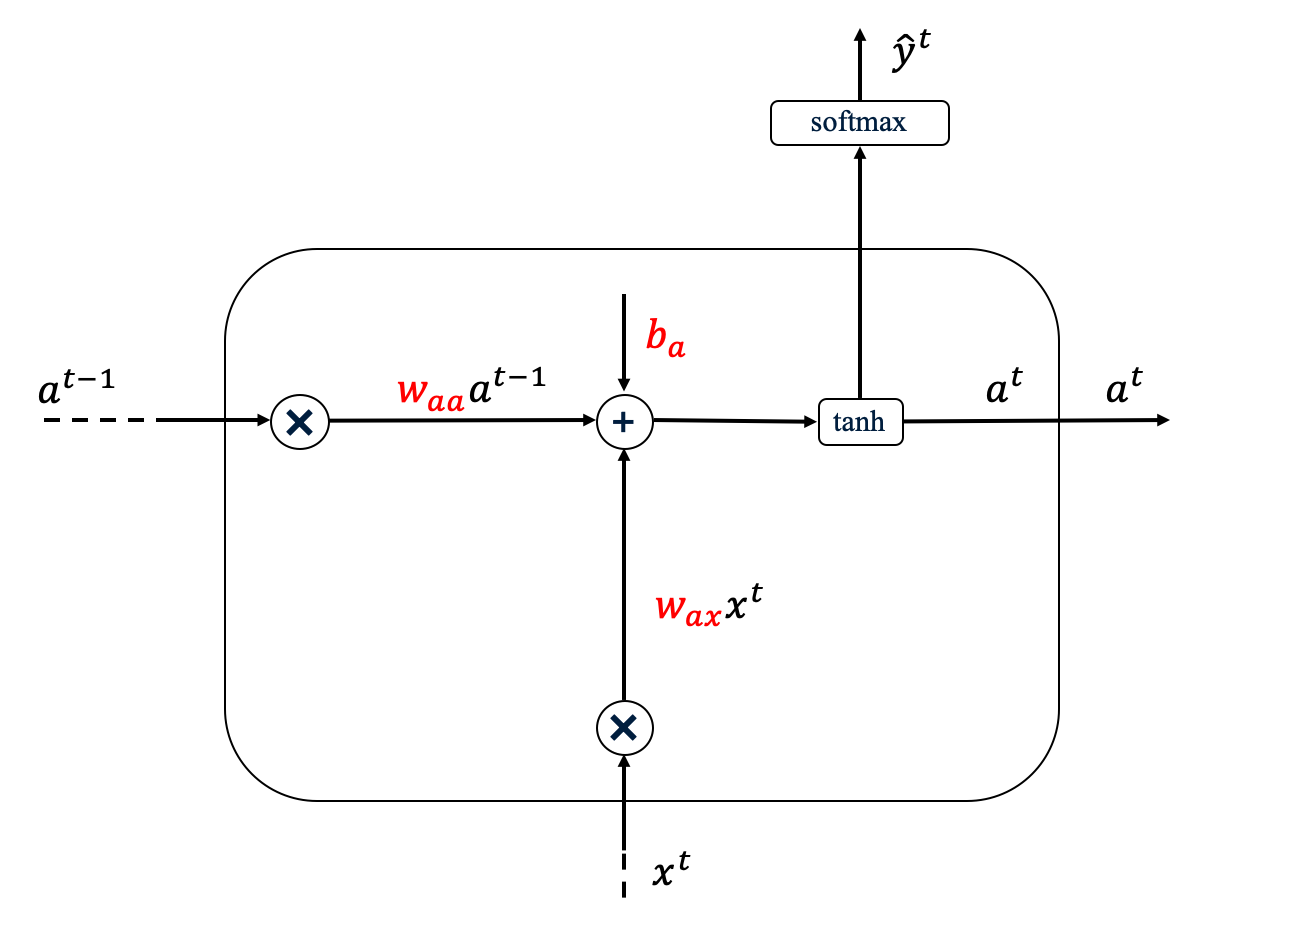

In the next step, we will implement this one cell processing using the [Keras](https://keras.io/) framework:

## A first recurrent layer in Keras

The `SimpleRNN` layer:


In [ ]:
from keras.layers import SimpleRNN

`SimpleRNN` processes batches of sequences. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [ ]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Training of RNNs is also performed with a backpropagation algorithm, slightly modified for this purpose.

For training, you need to specify optimisation method (optimizer) and loss function (loss).

Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [22]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 25s 152ms/step - loss: 0.6706 - acc: 0.5666 - val_loss: 0.5793 - val_acc: 0.6976
Epoch 2/10
157/157 [==============================] - 23s 149ms/step - loss: 0.4232 - acc: 0.8166 - val_loss: 0.3597 - val_acc: 0.8502
Epoch 3/10
157/157 [==============================] - 25s 158ms/step - loss: 0.2955 - acc: 0.8837 - val_loss: 0.3736 - val_acc: 0.8420
Epoch 4/10
157/157 [==============================] - 25s 157ms/step - loss: 0.2211 - acc: 0.9174 - val_loss: 0.3773 - val_acc: 0.8358
Epoch 5/10
157/157 [==============================] - 24s 155ms/step - loss: 0.1584 - acc: 0.9424 - val_loss: 0.4381 - val_acc: 0.8180
Epoch 6/10
157/157 [==============================] - 25s 157ms/step - loss: 0.1199 - acc: 0.9598 - val_loss: 0.5022 - val_acc: 0.7886
Epoch 7/10
157/157 [==============================] - 25s 157ms/step - loss: 0.0788 - acc: 0.9760 - val_loss: 0.5999 - val_acc: 0.7744
Epoch 8/10
157/157 [==============================] - 2

Let's display the training and validation loss and accuracy:

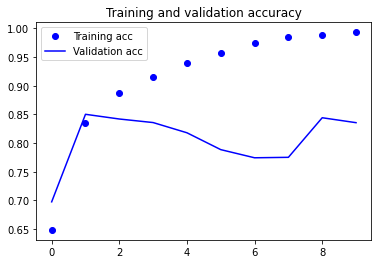

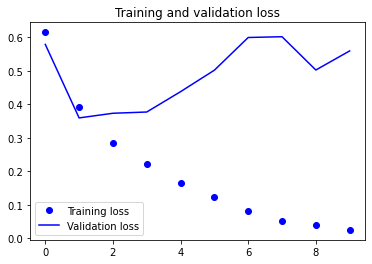

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Unfortunately, our small 
recurrent network doesn't perform very well at all. Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to very little information. 

The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. 

## LSTM (Long-Short Term Memory network)

We will use slightly more advanced model, which is called Long-Short Term Memory network.

On the figure below, you can see that an LSTM cell has more complex srtucture: it has another "parallel processing srteam" of information. We will not go much into the details of computations here, but just illustrate it's performance with an example.

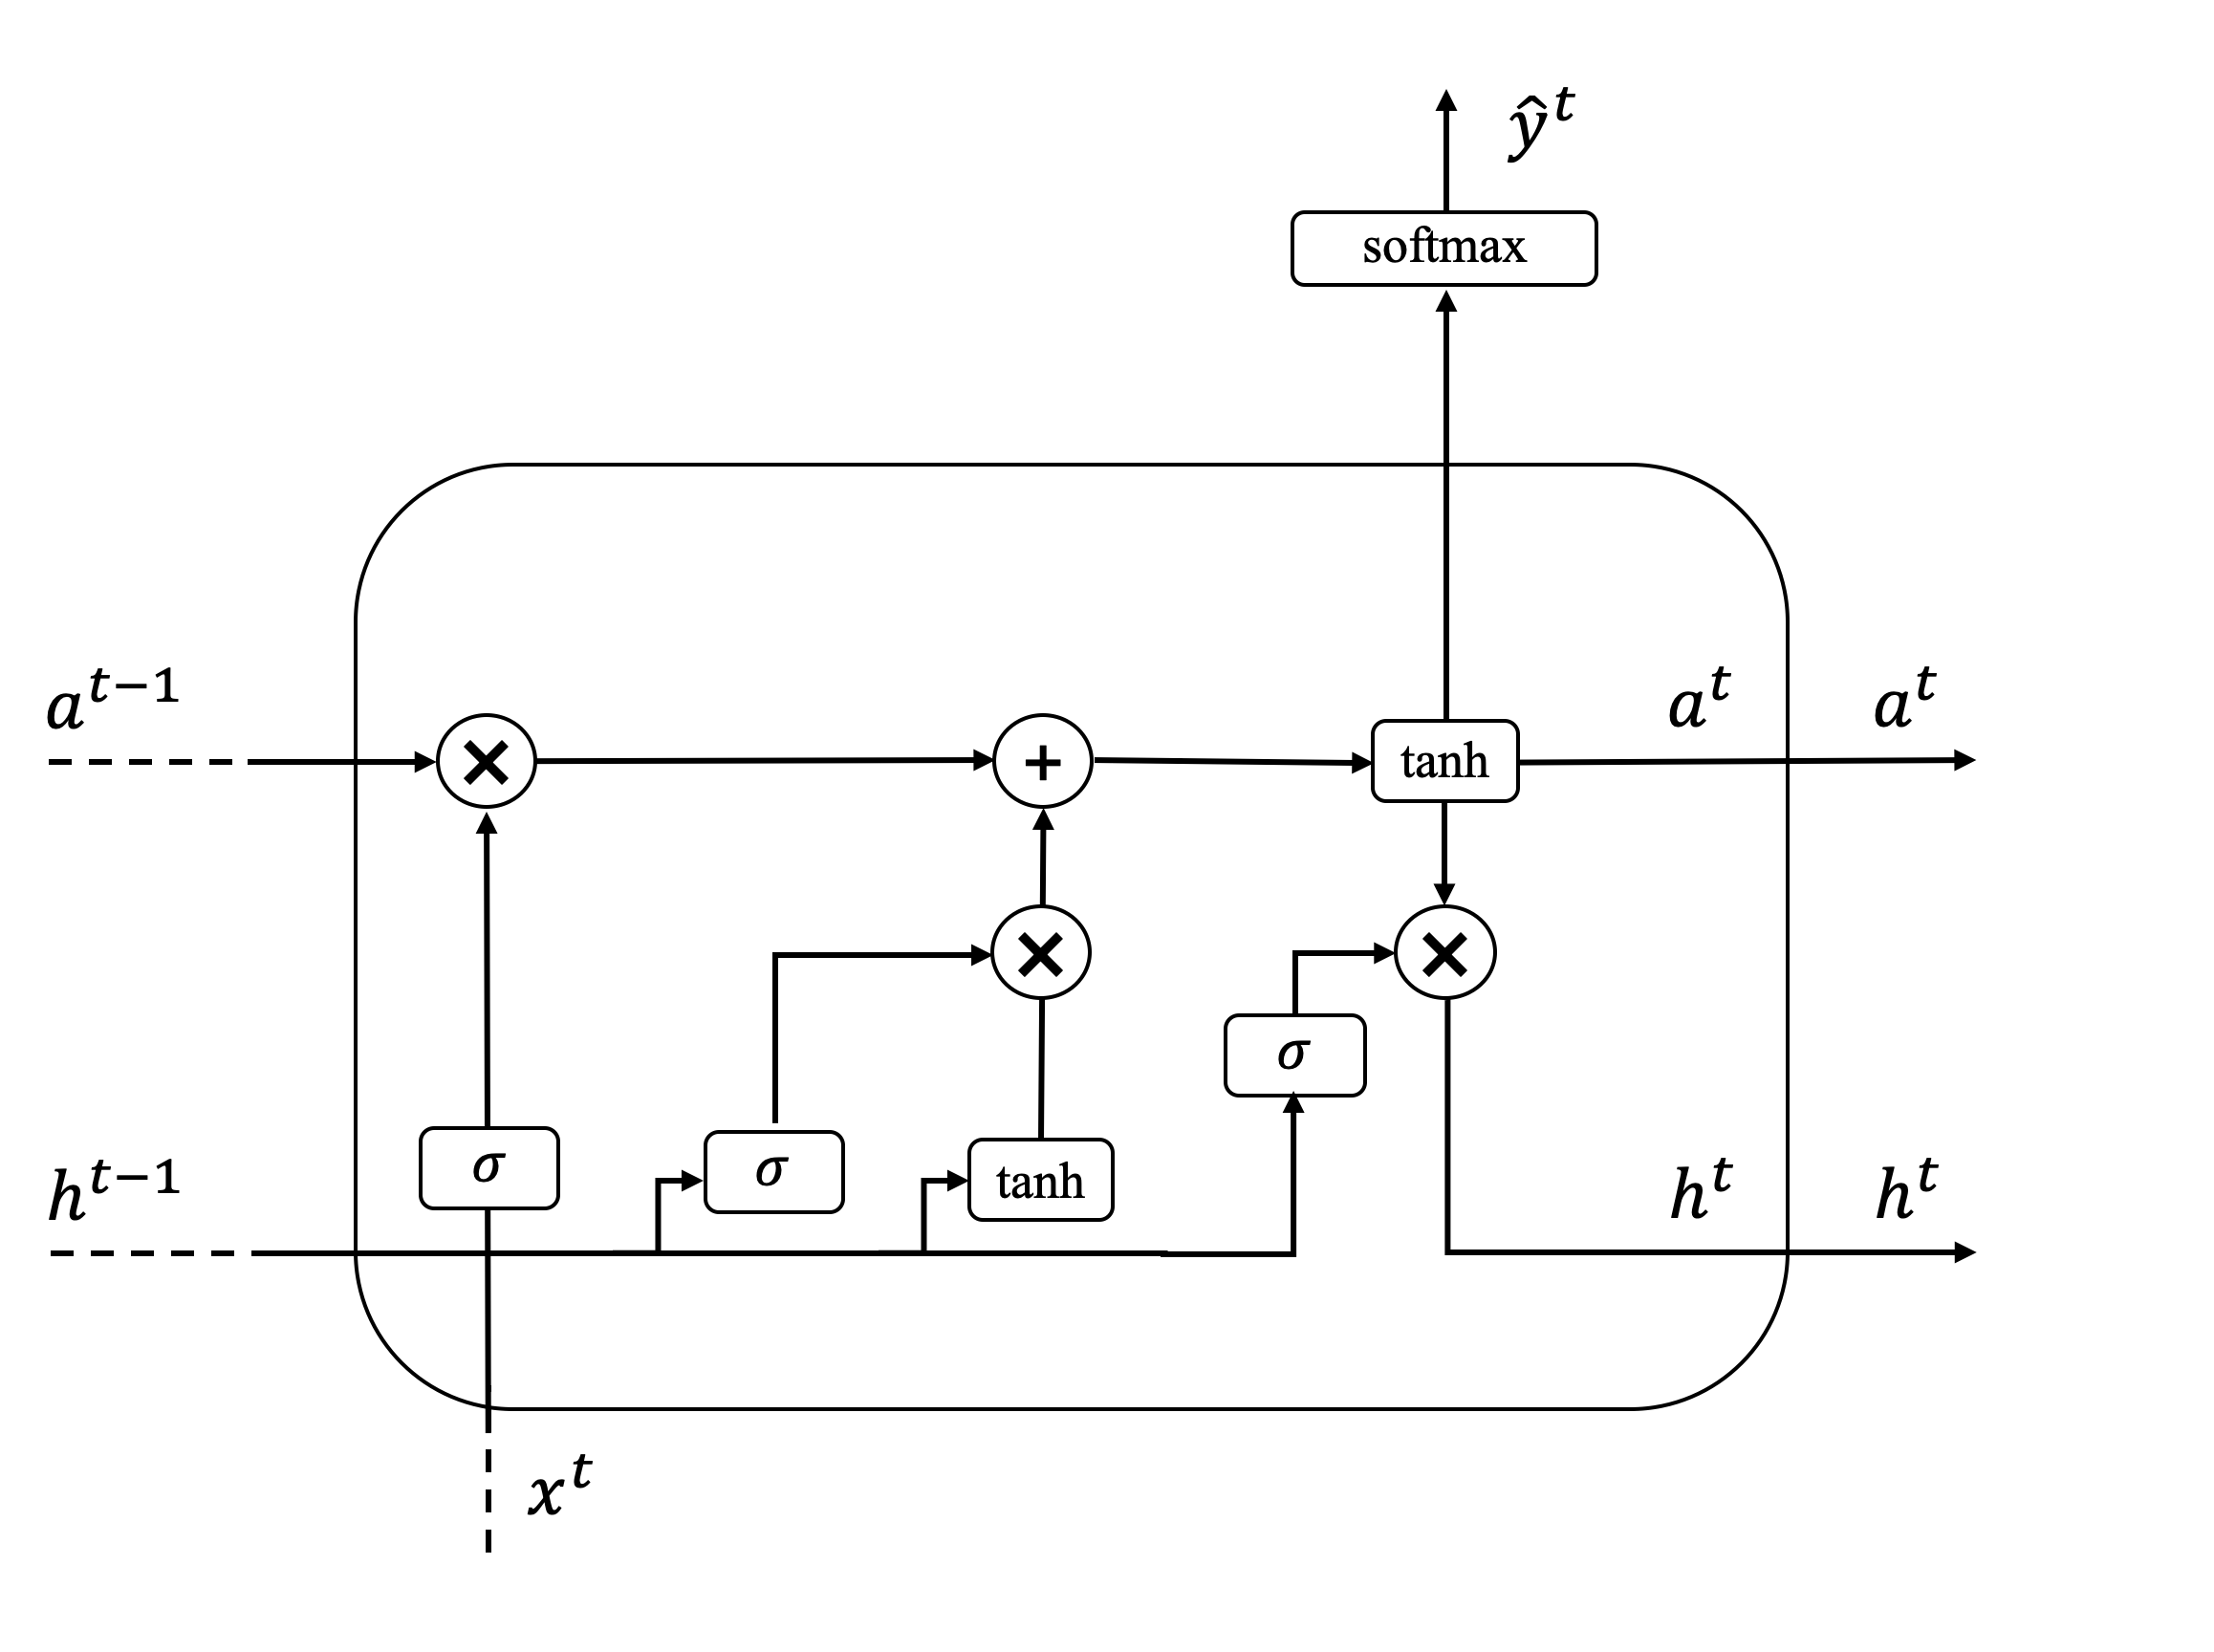

This model uses an LSTM layer instead of RNN. We will train it also on the IMDB data. 

Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10


In [ ]:
import matplotlib.pyplot as plt 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()